In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys

sys.path.append('/oasis/projects/nsf/csd181/yuncong/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.morphology import remove_small_objects, disk, remove_small_holes, binary_dilation
from skimage.io import imread, imsave
from skimage.util import img_as_ubyte
from skimage.segmentation import slic, mark_boundaries
from skimage.future.graph import rag_mean_color, cut_normalized, cut_threshold
from skimage.color import label2rgb
from scipy.stats import entropy
from scipy.sparse.linalg import ArpackError

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from annotation_utilities import contours_to_mask
from registration_utilities import find_contour_points

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Gordon

No vtk


In [54]:
fn = 'MD657-F58-2017.02.18-11.13.40_MD657_1_0172'
stack = 'MD657'

In [55]:
# submask_dir = create_if_not_exists(os.path.join(DATA_DIR, '%(stack)s/%(stack)s_submasks/%(fn)s' % \
#                                                 {'fn':fn, 'stack':stack}))
# execute_command('rm -f %s/*' % submask_dir);

In [56]:
VMAX_PERCENTILE = 99
VMIN_PERCENTILE = 1

In [57]:
tb_fmt = 'png'

In [58]:
img_rgb = imread(os.path.join(RAW_DATA_DIR, stack, '%(fn)s.%(tb_fmt)s' % dict(fn=fn, tb_fmt=tb_fmt)))

In [59]:
# # Don't use blue channel, dim bright at the background; the other channels are in fact more contrasty.
# rmax = img_rgb[..., 0].max()
# rmin = img_rgb[..., 0].min()
# rrange = rmax - rmin
# gmax = img_rgb[..., 1].max()
# gmin = img_rgb[..., 1].min()
# grange = gmax - gmin
# bmax = img_rgb[..., 2].max()
# bmin = img_rgb[..., 2].min()
# brange = bmax - bmin

rborder = np.median(np.r_[img_rgb[:10, :, 0].flatten(),
                                     img_rgb[-10:, :, 0].flatten(),
                                     img_rgb[:, :10, 0].flatten(),
                                     img_rgb[:, -10:, 0].flatten()])
gborder = np.median(np.r_[img_rgb[:10, :, 1].flatten(),
                                     img_rgb[-10:, :, 1].flatten(),
                                     img_rgb[:, :10, 1].flatten(),
                                     img_rgb[:, -10:, 1].flatten()])
bborder = np.median(np.r_[img_rgb[:10, :, 2].flatten(),
                                     img_rgb[-10:, :, 2].flatten(),
                                     img_rgb[:, :10, 2].flatten(),
                                     img_rgb[:, -10:, 2].flatten()])

# r_std = np.std(img_rgb[..., 0])
# g_std = np.std(img_rgb[..., 1])
# b_std = np.std(img_rgb[..., 2])

# r_ent = entropy(img_rgb[..., 0].flat)
# g_ent = entropy(img_rgb[..., 1].flat)
# b_ent = entropy(img_rgb[..., 2].flat)

# print rmax,rmin,rrange,rborder,r_std,r_ent
# print gmax,gmin,grange,gborder,g_std,g_ent
# print bmax,bmin,brange,bborder,b_std,b_ent

In [7]:
# fig, axes = plt.subplots(3, 1, sharex=True)

# axes[0].hist(img_rgb[..., 0].flatten(), bins=np.arange(0,255));
# axes[0].set_title('Red, std %f' % r_var);

# axes[1].hist(img_rgb[..., 1].flatten(), bins=np.arange(0,255));
# axes[1].set_title('Green, std %f' % g_var);

# axes[2].hist(img_rgb[..., 2].flatten(), bins=np.arange(0,255));
# axes[2].set_title('Blue, std %f' % b_var);

# plt.suptitle('Intensity');
# plt.tight_layout();
# plt.show();

In [60]:
from skimage.exposure import equalize_hist, equalize_adapthist, rescale_intensity

In [61]:
# stds = []
# ents = []
# orig_stds = []
# orig_ents = []
images = []
orig_images = []

for c in range(3):
    
    img = img_rgb[..., c].copy()

    if rborder < 123 and gborder < 123 and bborder < 123:
        # dark background, fluorescent
        img = img.max() - img # invert, make tissue dark on bright background
        
    orig_images.append(img.copy())
    
#     orig_std = np.std(img)
#     orig_stds.append(orig_std)
    
#     orig_ent = entropy(img.flat)
#     orig_ents.append(orig_ent)
    
    # plt.figure(figsize=(20,20));
    # plt.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255)
    # plt.title('Original');
    # plt.show();
    
    # Stretch contrast

    img_flattened= img.flatten()

    vmax_perc = VMAX_PERCENTILE
    while vmax_perc > 80:
        vmax = np.percentile(img_flattened, vmax_perc)
        if vmax < 255:
            break
        else:
            vmax_perc -= 1

    vmin_perc = VMIN_PERCENTILE
    while vmin_perc < 20:
        vmin = np.percentile(img_flattened, vmin_perc)
        if vmin > 0:
            break
        else:
            vmin_perc += 1

    sys.stderr.write('%d(%d percentile), %d(%d percentile)\n' % (vmin, vmin_perc, vmax, vmax_perc) )
    
#     img2 = img.copy()
#     img2[(img <= vmax) & (img >= vmin)] = 255./(vmax-vmin)*(img[(img <= vmax) & (img >= vmin)]-vmin)
#     img2[img > vmax] = 255
#     img2[img < vmin] = 0
#     img = img2.astype(np.uint8)

    img = rescale_intensity(img, in_range=(vmin, vmax))

    # plt.figure(figsize=(20,20));
    # plt.imshow(img, cmap=plt.cm.gray)
    # plt.title('Contrast Stretched');
    # plt.show();
    
    images.append(img)
    
#     std = np.std(img)
#     stds.append(std)
    
#     ent = entropy(img.flat)
#     ents.append(ent)

#     sys.stderr.write('std: %.2f, entropy: %.2f\n' % (std, ent))
#     sys.stderr.write('orig std: %.2f, orig entropy: %.2f\n' % (orig_std, orig_ent))

205(1 percentile), 248(99 percentile)
134(1 percentile), 251(99 percentile)
29(4 percentile), 253(99 percentile)


/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


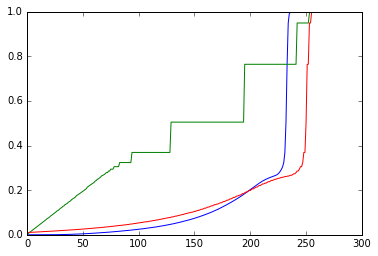

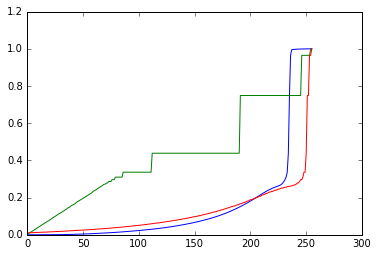

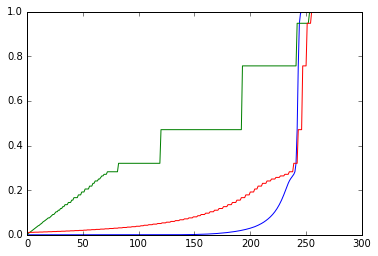

In [10]:
h, _ = np.histogram(img_as_ubyte(orig_images[0]).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

h, _ = np.histogram(img_as_ubyte(equalize_hist(orig_images[0])).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

# h, _ = np.histogram(img_as_ubyte(equalize_adapthist(orig_images[0])).flatten(), bins=np.arange(256+1), normed=True);
# plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

h, _ = np.histogram(img_as_ubyte(images[0]).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

plt.show();

###############
h, _ = np.histogram(img_as_ubyte(orig_images[1]).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

h, _ = np.histogram(img_as_ubyte(equalize_hist(orig_images[1])).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

# h, _ = np.histogram(img_as_ubyte(equalize_adapthist(orig_images[1])).flatten(), bins=np.arange(256+1), normed=True);
# plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

h, _ = np.histogram(img_as_ubyte(images[1]).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

plt.show();
#############

h, _ = np.histogram(img_as_ubyte(orig_images[2]).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

h, _ = np.histogram(img_as_ubyte(equalize_hist(orig_images[2])).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

# h, _ = np.histogram(img_as_ubyte(equalize_adapthist(orig_images[2])).flatten(), bins=np.arange(256+1), normed=True);
# plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

h, _ = np.histogram(img_as_ubyte(images[2]).flatten(), bins=np.arange(256+1), normed=True);
plt.plot(np.arange(256), np.cumsum(h) / np.sum(h));

plt.show();

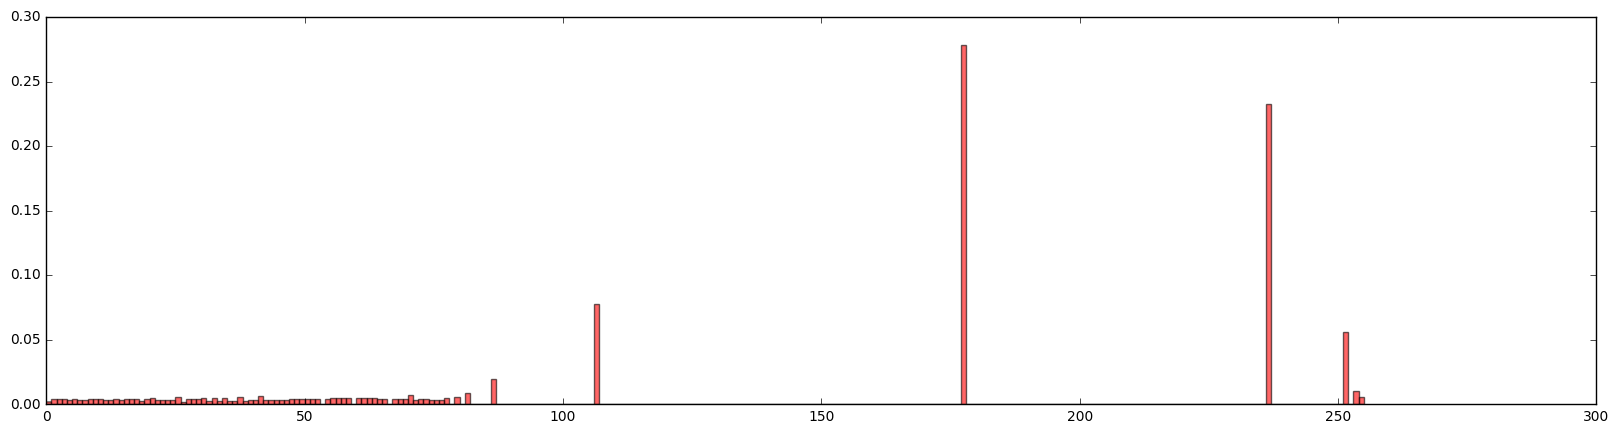

In [14]:
# plt.figure(figsize=(20,5));
# plt.hist(orig_images[0].flatten(), bins=np.arange(256), normed=True, alpha=.6, color='r');
# plt.hist(orig_images[1].flatten(), bins=np.arange(256), normed=True, alpha=.6, color='g');
# plt.hist(orig_images[2].flatten(), bins=np.arange(256), normed=True, alpha=.6, color='b');
# plt.title('Original (std R: %.2f, G: %.2f, B: %.2f)' % (orig_stds[0], orig_stds[1], orig_stds[2]), fontsize=20);
# plt.show();

# plt.figure(figsize=(20,5));
# plt.hist(images[0].flatten(), bins=np.arange(256), normed=True, alpha=.6, color='r');
# plt.hist(images[1].flatten(), bins=np.arange(256), normed=True, alpha=.6, color='g');
# plt.hist(images[2].flatten(), bins=np.arange(256), normed=True, alpha=.6, color='b');
# plt.title('Strecthed (std R: %.2f, G: %.2f, B: %.2f)' % (stds[0], stds[1], stds[2]), fontsize=20);
# plt.show();

plt.figure(figsize=(20,5));
plt.hist(img_as_ubyte(equalize_hist(orig_images[0])).flatten(), bins=np.arange(256), normed=True, alpha=.6, color='r');
# plt.hist(img_as_ubyte(equalize_hist(orig_images[1])).flatten(), bins=np.arange(256), normed=True, alpha=.6, color='g');
# plt.hist(img_as_ubyte(equalize_hist(orig_images[2])).flatten(), bins=np.arange(256), normed=True, alpha=.6, color='b');
plt.show();

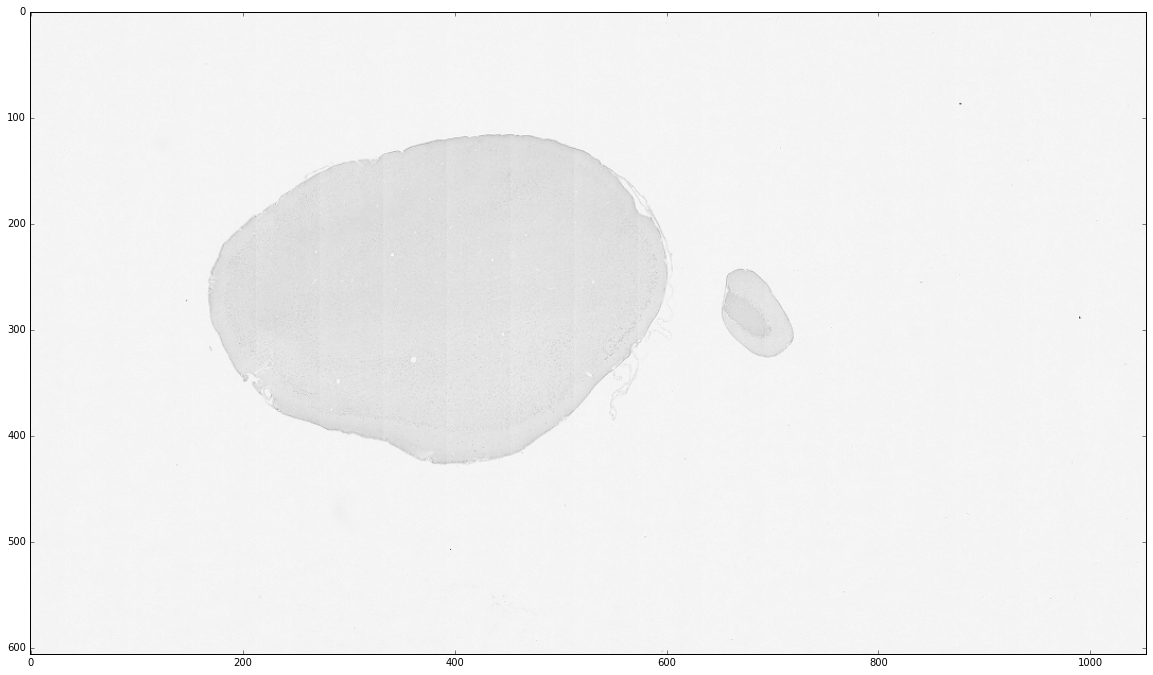

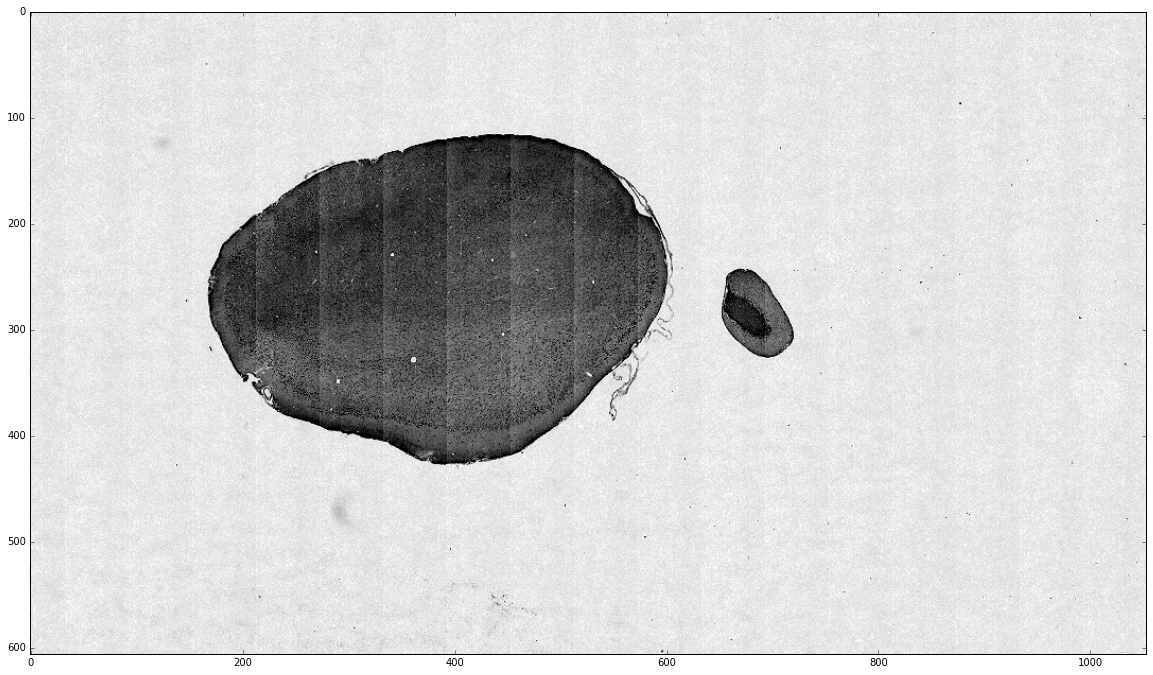

In [60]:
plt.figure(figsize=(20,20))
plt.imshow(orig_images[0], cmap=plt.cm.gray, vmin=0, vmax=255);
plt.show();

plt.figure(figsize=(20,20))
plt.imshow(img_as_ubyte(images[0]), cmap=plt.cm.gray, vmin=0, vmax=255);
plt.show();

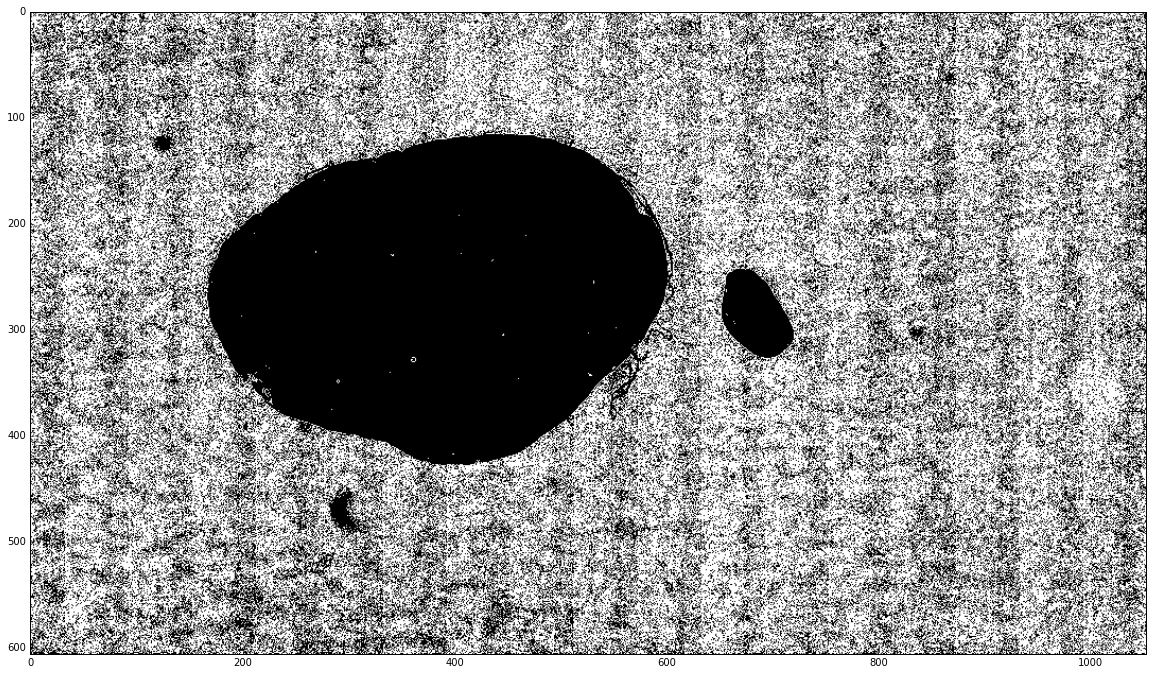

In [61]:
plt.figure(figsize=(20,20))
plt.imshow(img_as_ubyte(images[0] > 230), cmap=plt.cm.gray, vmin=0, vmax=255);
plt.show();

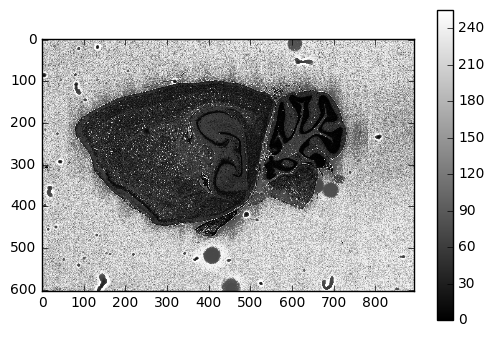

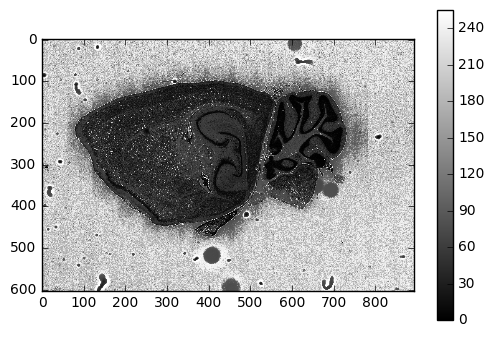

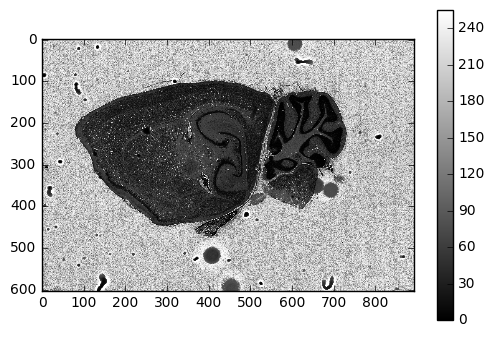

In [12]:
plt.imshow(img_as_ubyte(equalize_hist(orig_images[0])), cmap=plt.cm.gray, vmin=0, vmax=255);
plt.colorbar();
plt.show();

plt.imshow(img_as_ubyte(equalize_hist(orig_images[1])), cmap=plt.cm.gray, vmin=0, vmax=255);
plt.colorbar();
plt.show();

plt.imshow(img_as_ubyte(equalize_hist(orig_images[2])), cmap=plt.cm.gray, vmin=0, vmax=255);
plt.colorbar();
plt.show();

In [12]:
# fig, axes = plt.subplots(3,1, figsize=(20,10))
# axes[0].hist(orig_images[0].flatten(), bins=np.arange(256), normed=True);
# axes[0].set_title('Orig RED, std: %.2f, entropy: %.2f\n' % (orig_stds[0], orig_ents[0]), fontsize=20)
# axes[1].hist(orig_images[1].flatten(), bins=np.arange(256), normed=True);
# axes[1].set_title('Orig GREEN, std: %.2f, entropy: %.2f\n' % (orig_stds[1], orig_ents[1]), fontsize=20)
# axes[2].hist(orig_images[2].flatten(), bins=np.arange(256), normed=True);
# axes[2].set_title('Orig BLUE, std: %.2f, entropy: %.2f\n' % (orig_stds[2], orig_ents[2]), fontsize=20)
# plt.tight_layout();
# plt.show();

# fig, axes = plt.subplots(3,1, figsize=(20,10))
# axes[0].hist(images[0].flatten(), bins=np.arange(256), normed=True);
# axes[0].set_title('Stretched RED, std: %.2f, entropy: %.2f\n' % (stds[0], ents[0]), fontsize=20)
# axes[1].hist(images[1].flatten(), bins=np.arange(256), normed=True);
# axes[1].set_title('Stretched GREEN, std: %.2f, entropy: %.2f\n' % (stds[1], ents[1]), fontsize=20)
# axes[2].hist(images[2].flatten(), bins=np.arange(256), normed=True);
# axes[2].set_title('Stretched BLUE, std: %.2f, entropy: %.2f\n' % (stds[2], ents[2]), fontsize=20)
# plt.tight_layout();
# plt.show();

In [38]:
# best_channel_id = np.argmax(stds)
# # best_channel_id = np.argmax(stds[:2])
# # best_channel_id = np.argmax(ents)
# # best_channel_id = 1
# sys.stderr.write('Use channel %s.\n' % ['RED', 'GREEN', 'BLUE'][best_channel_id])
# img = images[best_channel_id]

In [1051]:
# vals = np.asarray(img.flatten())
# ticks = np.linspace(0, vals.max(), 256)
# percentages = [np.count_nonzero(vals < th) / float(len(vals)) for th in ticks]

# plt.plot(ticks, percentages);
# plt.show();

# grad = np.gradient(percentages, 3)
# plt.plot(ticks, grad)
# plt.show();

# h = np.gradient(grad, 3)
# plt.plot(ticks, h)
# plt.show();

In [1052]:
# # sys.stderr.write('Otsu threshold: %.2f.\n' % threshold_otsu(img))
# # thresh = 230
# thresh = ticks[50:][np.argsort(h[50:])][0]
# sys.stderr.write('threshold: %.2f.\n' % thresh)

In [1053]:
# # Gamma correction.

# GAMMA = 1. # if gamma > 1, image is darker.
# img = img_as_ubyte(img_as_float(img)**GAMMA)

# plt.figure(figsize=(20,20));
# plt.imshow(img, cmap=plt.cm.gray)
# plt.title('Gamma Corrected');
# plt.show();

In [62]:
SLIC_SIGMA = 2
SLIC_COMPACTNESS = 5
SLIC_N_SEGMENTS = 400 # 200 causes many superpixels to cross obvious boundaries. 400 is good, 20 per dimension.
SLIC_MAXITER = 100

In [13]:
# slic_labels_allChannel = []
# sp_max_stds = []

# for c in range(3):
#     t = time.time()
#     slic_labels_ = slic(images[c].astype(np.float), sigma=SLIC_SIGMA, compactness=SLIC_COMPACTNESS, 
#                        n_segments=SLIC_N_SEGMENTS, multichannel=False, max_iter=SLIC_MAXITER)
#     sys.stderr.write('SLIC: %.2f seconds.\n' % (time.time() - t)) # 10 seconds, iter=100, nseg=1000;
#     slic_labels_allChannel.append(slic_labels_)
    
#     sp_max_std = np.percentile([images[c][slic_labels_ == l].std() for l in np.unique(slic_labels_)], 90)
#     sys.stderr.write('sp_max_std = %.2f.\n' % sp_max_std)
#     sp_max_stds.append(sp_max_std)

# best_channel_id = np.argmin(sp_max_stds)
# sys.stderr.write('Use channel %s.\n' % ['RED', 'GREEN', 'BLUE'][best_channel_id])
# slic_labels = slic_labels_allChannel[best_channel_id]
# img = images[best_channel_id]

In [14]:
# grey_thresh = 239
# img = img_as_ubyte(img > grey_thresh)

In [63]:
img = images[0]

In [64]:
# Input to slic() must be float

t = time.time()
slic_labels = slic(img.astype(np.float), sigma=SLIC_SIGMA, compactness=SLIC_COMPACTNESS, n_segments=SLIC_N_SEGMENTS, 
                   multichannel=False, max_iter=SLIC_MAXITER)
sys.stderr.write('SLIC: %.2f seconds.\n' % (time.time() - t)) # 10 seconds, iter=100, nseg=1000;

SLIC: 11.06 seconds.


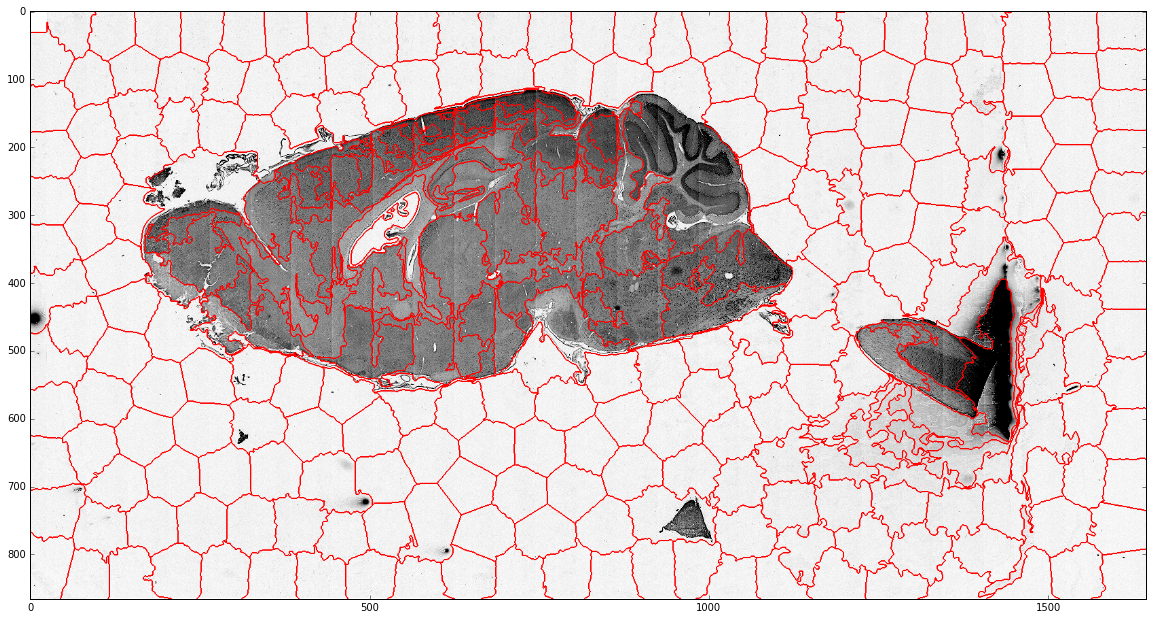

In [65]:
slic_boundaries = mark_boundaries(img, label_img=slic_labels, background_label=-1, color=(1,0,0))
plt.figure(figsize=(20,20));
plt.imshow(slic_boundaries);
plt.show();

In [66]:
SUPERPIXEL_SIMILARITY_SIGMA = 50. # higher value means greater affinity between superpixels.

In [406]:
# Build affinity graph.

# t = time.time()
# sim_graph = rag_mean_color(img, slic_labels, mode='similarity', sigma=SUPERPIXEL_SIMILARITY_SIGMA)
# sys.stderr.write('Build affinity graph: %.2f seconds.\n' % (time.time() - t)) # 20 seconds

# edge_weights = np.array([a['weight'] for n, d in sim_graph.adjacency_iter() for a in d.itervalues()])

# percentages = [np.count_nonzero(edge_weights < th) / float(len(edge_weights)) for th in np.linspace(0, 1, 100)]

# plt.plot(np.linspace(0, 1, 100), percentages);
# plt.title('Cumulative distribution of superpixel affinity');
# plt.xlabel('Edge affinity');
# plt.show();

In [407]:
# SUPERPIXEL_MERGE_SIMILARITY_THRESH = .2
# # threshold on affinity; edge whose affinity is above this value is not further split. 
# # if edge affinity is below this value, do further split.
# # Higher value means more sensitive to slight intensity difference.

# GRAPHCUT_NUM_CUTS = 20

In [408]:
# # Recursively perform binary normalized cut.

# for _ in range(3):
#     try:

#         t = time.time()
#         ncut_labels = cut_normalized(slic_labels, sim_graph, in_place=False, 
#                                      thresh=SUPERPIXEL_MERGE_SIMILARITY_THRESH,
#                                      num_cuts=GRAPHCUT_NUM_CUTS)

#         sys.stderr.write('Normalized Cut: %.2f seconds.\n' % (time.time() - t)) # 1.5s for SLIC_N_SEGMENTS=200 ~ O(SLIC_N_SEGMENTS**3)
#         break

#     except ArpackError as e:
#         sys.stderr.write('ArpackError encountered.\n')
#         continue


In [67]:
ncut_labels = slic_labels

In [68]:
ncut_boundaries_viz = mark_boundaries(img, label_img=ncut_labels, background_label=-1, color=(1,0,0))

In [69]:
# plt.figure(figsize=(20,20));
# plt.imshow(ncut_boundaries_viz);
# plt.show();

In [69]:
# Find background superpixels.

background_labels = np.unique(np.concatenate([ncut_labels[:,0], ncut_labels[:,-1], 
                                              ncut_labels[0,:], ncut_labels[-1,:]]))

In [70]:
BORDER_DISSIMILARITY_PERCENTILE = 30
MIN_SIZE = 100

In [71]:
# Collect border superpixels.

border_histos = []
for b in background_labels:
    histo = np.histogram(img[ncut_labels == b], bins=np.arange(0,256,5))[0].astype(np.float)
    histo = histo/np.sum(histo)
    border_histos.append(histo)
    
# for histo in train_histos:
#     plt.bar(np.arange(0,255,5)[:-1], histo);
#     plt.show();

# Compute dissimilarity of superpixels to border superpixels.

histos = {}
for l in np.unique(ncut_labels):
    histo = np.histogram(img[ncut_labels == l], bins=np.arange(0,256,5))[0].astype(np.float)
    histo = histo/np.sum(histo)
    histos[l] = histo
    
hist_distances = {}
for l, h in histos.iteritems():
    hist_distances[l] = np.percentile([chi2(h, th) for th in border_histos], BORDER_DISSIMILARITY_PERCENTILE)
    # min is too sensitive if there is a blob at the border
    
# plt.hist(hist_distances.values(), bins=np.arange(0,2,.005));
# plt.title('Superpixel dissimilarity to border superpixels');
# plt.xlabel('Chi2 distance');
# plt.show();

dist_vals = np.asarray(hist_distances.values())
ticks = np.linspace(0, dist_vals.max(), 100)

percentages = [np.count_nonzero(dist_vals < th) / float(len(dist_vals)) for th in ticks]

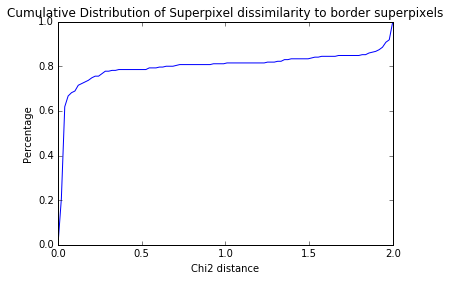

In [72]:
plt.plot(ticks, percentages);
plt.title('Cumulative Distribution of Superpixel dissimilarity to border superpixels');
plt.ylabel('Percentage');
plt.xlabel('Chi2 distance');
plt.show();

In [73]:
FOREGROUND_DISSIMILARITY_THRESHOLD_MAX = 1.5
INIT_CONTOUR_COVERAGE_MAX = .5

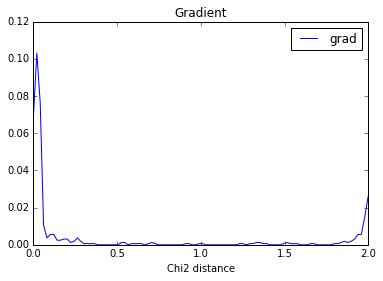

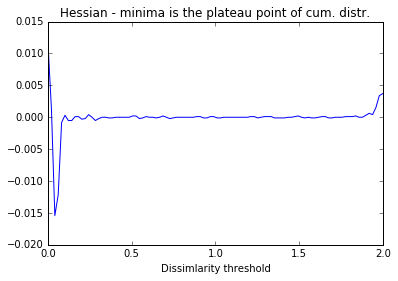

[ 0.38365712  0.4038496   0.42404208  0.44423456  0.46442704  0.48461952
  0.504812    0.56538944  0.66635184  0.74712176]
FOREGROUND_DISSIMILARITY_THRESHOLD = 0.383657119277


In [74]:
# Strategy: Select the lowest threshold (most inclusive) while covers less than 50% of the image (avoid over-inclusiveness).

def moving_average(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

grad= np.gradient(percentages, 3)
# smoothed_grad = moving_average(grad, 1)

plt.plot(ticks, grad, label='grad');
# plt.plot(ticks, smoothed_grad, label='smoothed');
plt.legend();
plt.title('Gradient');
plt.xlabel('Chi2 distance');
plt.show();

# Identify the leveling point
h = np.gradient(grad, 3)

plt.plot(ticks, h);
plt.title('Hessian - minima is the plateau point of cum. distr.');
plt.xlabel('Dissimlarity threshold');
# plt.savefig(os.path.join(submask_dir, '%(fn)s_spDissimCumDistHessian.png' % dict(fn=fn)));
plt.show()

# print ticks[h.argsort()]
# print ticks[np.argsort(smoothed_grad, kind='mergesort')]

# ticks_sorted = ticks[10:][h[10:].argsort()]
# ticks_sorted = ticks[find_score_peaks(-h, min_distance=5)[0]]
ticks_sorted = ticks[np.argsort(grad, kind='mergesort')] # Only mergesort is "stable".
# ticks_sorted = ticks[np.argsort(smoothed_grad, kind='mergesort')] # Only mergesort is "stable".
ticks_sorted_reduced = ticks_sorted[ticks_sorted < FOREGROUND_DISSIMILARITY_THRESHOLD_MAX]

init_contour_percentages = np.asarray([np.sum([np.count_nonzero(ncut_labels == l) 
                                               for l, d in hist_distances.iteritems() 
                                               if d > th]) / float(img.size) 
                                       for th in ticks_sorted_reduced])

threshold_candidates = ticks_sorted_reduced[(init_contour_percentages < INIT_CONTOUR_COVERAGE_MAX) &\
                                                          (init_contour_percentages > 0)]
# np.savetxt(os.path.join(submask_dir, '%(fn)s_spThreshCandidates.txt' % dict(fn=fn)), threshold_candidates, fmt='%.3f')

print threshold_candidates[:10]
FOREGROUND_DISSIMILARITY_THRESHOLD = threshold_candidates[0]

print 'FOREGROUND_DISSIMILARITY_THRESHOLD =', FOREGROUND_DISSIMILARITY_THRESHOLD

In [28]:
# superpixel_border_distances = np.zeros_like(img, np.float)
# for l, s in hist_distances.iteritems():
#     superpixel_border_distances[ncut_labels == l] = s
    
# # plt.figure(figsize=(20,20));
# im = plt.imshow(superpixel_border_distances, vmin=0, vmax=2);
# plt.title('Superpixels distance to border');
# plt.colorbar(im, fraction=0.025, pad=0.02);

# plt.savefig(os.path.join(submask_dir, '%(fn)s_spBorderDissim.png' % dict(fn=fn)));

In [29]:
# FOREGROUND_DISSIMILARITY_THRESHOLD = 0.4

In [75]:
# Generate mask for snake's initial contours.

# t = time.time()

superpixel_mask = np.zeros_like(img, np.bool)
for l, d in hist_distances.iteritems():
    if d > FOREGROUND_DISSIMILARITY_THRESHOLD:
        superpixel_mask[ncut_labels == l] = 1
        
# sys.stderr.write('Get mask from foreground superpixels: %.2f seconds.\n' %  (time.time() - t)) # 50 seconds.

In [76]:
superpixel_mask = remove_small_objects(superpixel_mask, min_size=200)

In [77]:
labelmap, n_submasks = label(superpixel_mask, return_num=True)

In [78]:
superpixel_submasks = []
dilated_superpixel_submasks = []

for i in range(1, n_submasks+1):
    m = labelmap == i
    superpixel_submasks.append(m)
    
    dilated_m = binary_dilation(m, disk(10))
    dilated_m = remove_small_objects(remove_small_holes(dilated_m, min_size=2000), min_size=MIN_SIZE)
    dilated_superpixel_submasks.append(dilated_m)

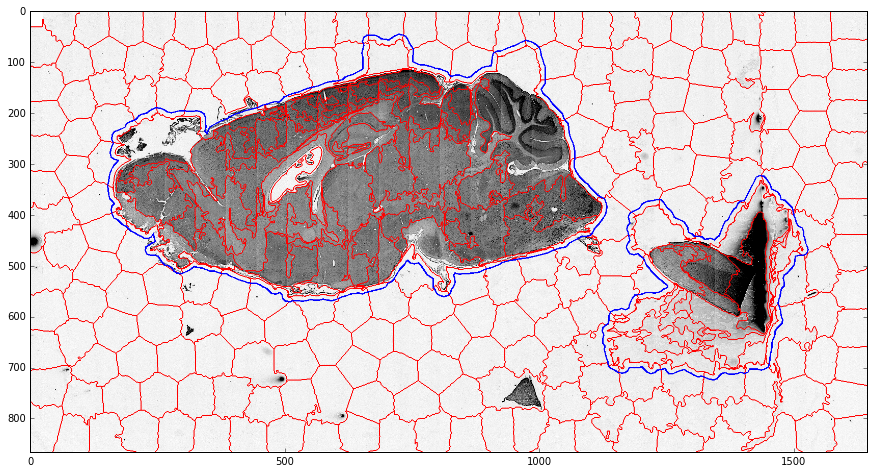

In [79]:
# Visualize

viz = img_as_ubyte(ncut_boundaries_viz)

for submask in superpixel_submasks:
    for cnt in find_contour_points(submask)[1]:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (255,0,0), 1) # red

for submask in dilated_superpixel_submasks:
    for cnt in find_contour_points(submask)[1]:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (0,0,255), 2) # blue
    
plt.figure(figsize=(15,15));
plt.imshow(viz);
plt.show();

In [80]:
INIT_CONTOUR_MINLEN = 50

In [81]:
# Find contours from mask.

# orig_init_contours = [xys for xys in find_contour_points(superpixel_mask.astype(np.int), sample_every=1)[1] 
#                  if len(xys) > 50]

# init_contours = [xys for submask in dilated_superpixel_submasks 
#                  for xys in find_contour_points(submask.astype(np.int), sample_every=1)[1] 
#                  if len(xys) > INIT_CONTOUR_MINLEN]

init_contours = []
for submask in dilated_superpixel_submasks:
    cnts = find_contour_points(submask.astype(np.int), sample_every=1)
    if 1 not in cnts or len(cnts[1]) == 0:
        continue
    for cnt in cnts[1]:
        if len(cnt) > INIT_CONTOUR_MINLEN:
            init_contours.append(cnt)

# assert len(init_contours) > 0, 'No contour is detected from entropy mask %s' % fn
sys.stderr.write('Extracted %d contours from mask.\n' % len(init_contours))

Extracted 2 contours from mask.


In [82]:
# Option 1: Morphsnake approach

# Create initial levelset

# from scipy.stats import entropy

init_levelsets = []
for cnt in init_contours:
    init_levelset = np.zeros_like(img, np.float)
    
    t = time.time()
    init_levelset[contours_to_mask([cnt], img.shape[:2])] = 1.
    sys.stderr.write('Contour to levelset: %.2f seconds\n' % (time.time() - t)) # 10s
    
    init_levelset[:10, :] = 0
    init_levelset[-10:, :] = 0
    init_levelset[:, :10] = 0
    init_levelset[:, -10:] = 0
    
    init_levelsets.append(init_levelset)

Contour to levelset: 4.01 seconds
Contour to levelset: 0.74 seconds


In [83]:
MORPHSNAKE_SMOOTHING = 1
MORPHSNAKE_LAMBDA1 = 1 # imprtance of inside pixels
MORPHSNAKE_LAMBDA2 = 20 # imprtance of outside pixels
# Only relative lambda1/lambda2 matters, large = shrink, small = expand
MORPHSNAKE_MAXITER = 600
MORPHSNAKE_MINITER = 10
PIXEL_CHANGE_TERMINATE_CRITERIA = 3
AREA_CHANGE_RATIO_MAX = 1.2
AREA_CHANGE_RATIO_MIN = .1

In [84]:
import morphsnakes
from collections import deque

In [85]:
# msnake = morphsnakes.MorphACWE(img_enhanced.astype(np.float), smoothing=int(MORPHSNAKE_SMOOTHING), 
#                                    lambda1=MORPHSNAKE_LAMBDA1, lambda2=MORPHSNAKE_LAMBDA2)
# # msnake = morphsnakes.MorphACWE(img.astype(np.float), smoothing=int(MORPHSNAKE_SMOOTHING), 
# #                                    lambda1=MORPHSNAKE_LAMBDA1, lambda2=MORPHSNAKE_LAMBDA2)
# # 0-255 is same as 0-1

# msnake.levelset = init_levelsets[2].copy()

# init_area = np.count_nonzero(msnake.levelset)

# for i in range(MORPHSNAKE_MAXITER):
#     msnake.step()
#     if i % 10 == 0:
# #         viz = img_rgb.copy()
# #         viz = gray2rgb(img_rgb[...,0])
# #         viz = gray2rgb((img>230).astype(np.float)*255)
# #         viz = gray2rgb(img_as_ubyte(img2))
#         viz = gray2rgb(img)
        
#         cnts = find_contour_points(msnake.levelset)
#         for cnt in cnts[1]:
#             cv2.polylines(viz, [cnt.astype(np.int)], True, (255,0,0), 3) # red

#         plt.imshow(viz.astype(np.uint8));
#         plt.show();
        
#         print np.count_nonzero(msnake.levelset)/float(init_area)

In [337]:
# all_fg_pixels = np.concatenate([img[m].flatten() for m in superpixel_submasks])
# all_fg_pixels_valid = all_fg_pixels[(all_fg_pixels > 0) & (all_fg_pixels < 255)]

# grey_hist, greyvals = np.histogram(all_fg_pixels_valid, bins=np.arange(256), density=True);

# plt.figure(figsize=(10,2));
# plt.bar(greyvals[:-1], grey_hist);

In [338]:
# # grey_thresh = all_fg_pixels_valid.max() - 1
# grey_thresh = 200

# sys.stderr.write('Grey threshold: %d.\n' % grey_thresh)

# img_enhanced = img_as_ubyte(img > grey_thresh)

# fig, axes = plt.subplots(1,2, figsize=(20,10))
# axes[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255);
# axes[1].imshow(img_enhanced, cmap=plt.cm.gray, vmin=0, vmax=1);
# plt.show();

In [86]:
img_enhanced = img.copy()

In [36]:
# img_enhanced = orig_images[0].copy()


Contour 1


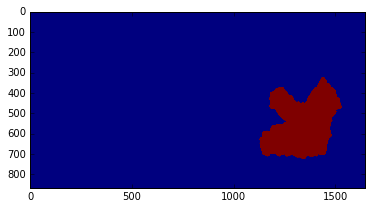

99786 99786.0
98609 99786.0
97350 99786.0
95875 99786.0
94401 99786.0
92955 99786.0
91507 99786.0
90114 99786.0
88712 99786.0
87322 99786.0
85942 99786.0
84589 99786.0
83241 99786.0
81925 99786.0
80621 99786.0
79346 99786.0
78089 99786.0
76907 99786.0
75739 99786.0
74639 99786.0
73547 99786.0
72520 99786.0
71475 99786.0
70498 99786.0
69489 99786.0
68571 99786.0
67612 99786.0
66729 99786.0
65785 99786.0
64959 99786.0
63961 99786.0
63071 99786.0
62162 99786.0
61358 99786.0
60495 99786.0
59743 99786.0
58913 99786.0
58183 99786.0
57376 99786.0
56664 99786.0
55878 99786.0
55199 99786.0
54455 99786.0
53840 99786.0
53132 99786.0
52568 99786.0
51897 99786.0
51369 99786.0
50716 99786.0
50217 99786.0
49570 99786.0
49076 99786.0
48443 99786.0
47965 99786.0
47342 99786.0
46880 99786.0
46281 99786.0
45861 99786.0
45297 99786.0
44900 99786.0
44361 99786.0
43989 99786.0
43475 99786.0
43138 99786.0
42364 99786.0
41905 99786.0
41379 99786.0
41072 99786.0
40628 99786.0
40359 99786.0
39942 99786.0
39699 

Snake finished at iteration 149.
Snake: 53.71 seconds


SyntaxError: 'continue' not properly in loop (<ipython-input-90-a0010bae8a07>, line 85)

In [90]:
#####################
# Evolve morphsnake #
#####################

final_masks = []

# for levelset_ind, init_levelset in enumerate(init_levelsets):
levelset_ind = 1
init_levelset = init_levelsets[levelset_ind]

sys.stderr.write('\nContour %d\n' % levelset_ind)

discard = False
init_area = np.count_nonzero(init_levelset)

t = time.time()

msnake = morphsnakes.MorphACWE(img_enhanced.astype(np.float), smoothing=int(MORPHSNAKE_SMOOTHING), 
                               lambda1=5, lambda2=MORPHSNAKE_LAMBDA2)

msnake.levelset = init_levelset.copy()

plt.imshow(init_levelset)
plt.show();

dq = deque([None, None])
for i in range(MORPHSNAKE_MAXITER): 

    # At stable stage, the levelset (thus contour) will oscilate, 
    # so instead of comparing to previous levelset, must compare to the one before the previous
    oneBefore_levelset = dq.popleft()

    # If less than 3 pixels are changed, stop.
    if i > MORPHSNAKE_MINITER:
        if np.count_nonzero(msnake.levelset - oneBefore_levelset) < PIXEL_CHANGE_TERMINATE_CRITERIA:
            break

    area = np.count_nonzero(msnake.levelset)

    if area < MIN_SIZE:
        discard = True
        sys.stderr.write('Too small, stop iteration.\n')
        break

    # If area changes more than 2, stop.

    labeled_mask = label(msnake.levelset.astype(np.bool))
    for l in np.unique(labeled_mask):
        if l != 0:
            m = labeled_mask == l
            if np.count_nonzero(m)/float(init_area) > AREA_CHANGE_RATIO_MAX:
                msnake.levelset[m] = 0
                sys.stderr.write('Area nullified.\n')

#         area_change_ratio = area/float(init_area)
#         sys.stderr.write('Area change: %.2f.\n' % area_change_ratio)
#         if area_change_ratio > AREA_CHANGE_RATIO_MAX:
#             discard = True
#             sys.stderr.write('Area increases too much, stop iteration.\n')
#             break  

#     plt.figure();
#     plt.imshow(msnake.levelset);
#     plt.show();

    print np.count_nonzero(msnake.levelset), float(init_area)

    if  np.count_nonzero(msnake.levelset)/float(init_area) < AREA_CHANGE_RATIO_MIN:
        discard = True
        sys.stderr.write('Area shrinks too much, stop iteration.\n')
        break

    dq.append(msnake.levelset)

#         t = time.time()
    msnake.step()
#         sys.stderr.write('Step: %f seconds\n' % (time.time()-t)) # 0.6 second/step, roughly 200 steps takes 120s


sys.stderr.write('Snake finished at iteration %d.\n' % i)
sys.stderr.write('Snake: %.2f seconds\n' % (time.time()-t)) # 72s

if discard:
    sys.stderr.write('Discarded.\n')
    continue
else:
    # Handles the case that a single initial contour morphs into multiple contours
    labeled_mask = label(msnake.levelset.astype(np.bool))
    for l in np.unique(labeled_mask):
        if l != 0:
            m = labeled_mask == l
            if np.count_nonzero(m) > MIN_SIZE:
                final_masks.append(m)
                sys.stderr.write('Final masks added.\n')

# Export

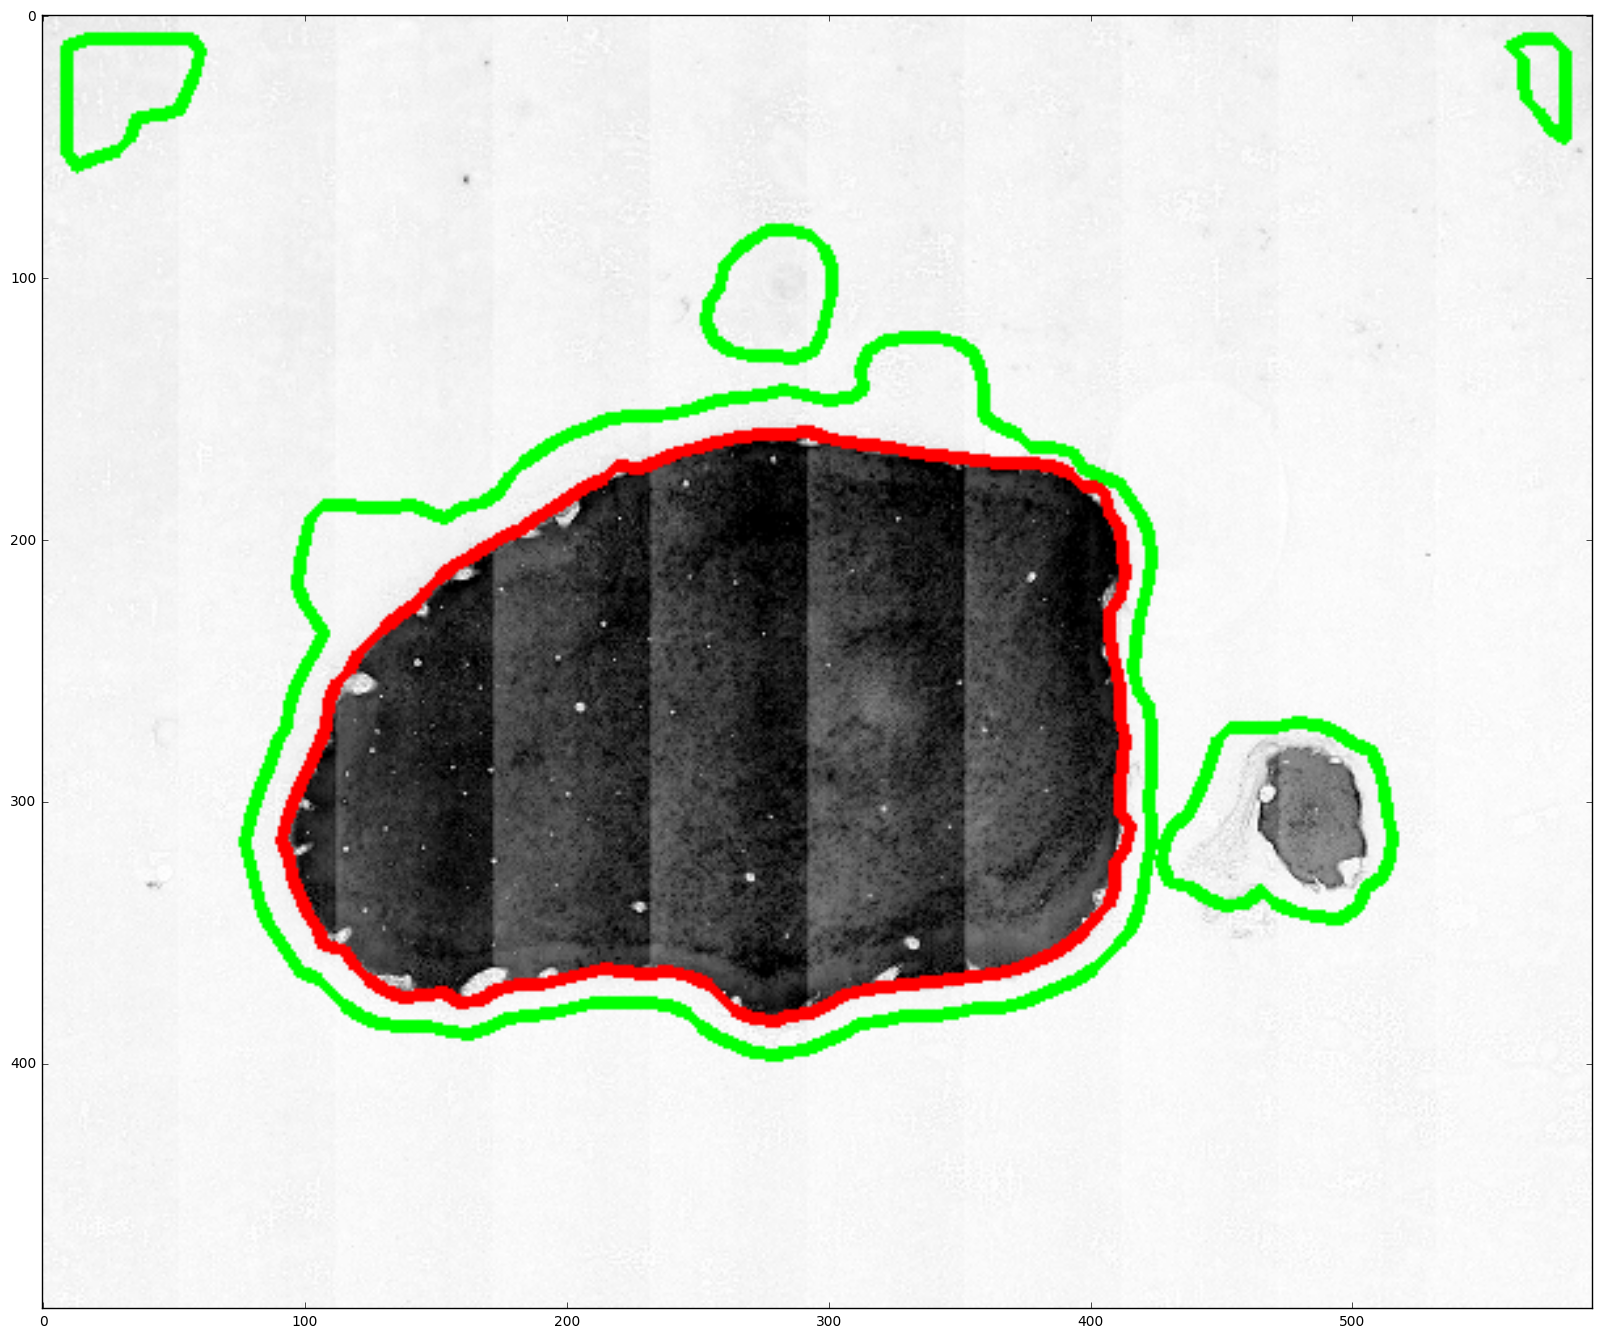

In [396]:
# submask_dir = create_if_not_exists('/home/yuncong/CSHL_data_processed/%(stack)s/%(stack)s_submasks/%(fn)s' % {'fn':fn, 'stack':stack})
# execute_command('rm -f %s/*' % submask_dir)

# img_rgb = imread(os.path.join(input_dir, fn + '.' + tb_fmt))

all_init_cnts = []
for i, init_levelset in enumerate(init_levelsets):
    all_init_cnts += find_contour_points(init_levelset)[1]

viz = gray2rgb(img_enhanced)
    
for i, mask in enumerate(final_masks):
    
#     imsave(os.path.join(submask_dir,'%(fn)s_submask_%(i)d.png' % {'fn': fn, 'i':i+1}), img_as_ubyte(mask))
#     plt.imshow(mask, cmap=plt.cm.gray);
#     plt.show();
    
    cnts = find_contour_points(mask)
    if len(cnts) == 0:
        raise
    for cnt in cnts[1]:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (255,0,0), 3) # red
        
    for cnt in all_init_cnts:
        cv2.polylines(viz, [cnt.astype(np.int)], True, (0,255,0), 3) # green

#     viz_fn = os.path.join(submask_dir, '%(fn)s_submask_%(i)d_overlayViz.tif' % dict(fn=fn, i=i+1))
#     sys.stderr.write(viz_fn + '\n')
#     imsave(viz_fn, viz)
    
plt.figure(figsize=(20,20));
plt.imshow(viz);
plt.show();

# Automatically judge the goodness of each mask

In [70]:
n = len(final_masks)

In [71]:
rank1 = np.argsort([np.count_nonzero(m) for m in final_masks])[::-1]

bbox_to_image_center_distance = []
for m in final_masks:
    xmin, xmax, ymin, ymax = bbox_2d(m)
    dist = np.sqrt(np.sum((np.r_[img.shape[1]/2, img.shape[0]/2] - ((xmin + xmax)/2, (ymin+ymax)/2))**2))
    bbox_to_image_center_distance.append(dist)
    
rank2 = np.argsort(bbox_to_image_center_distance)

r1 = np.asarray([r for r, i in sorted(enumerate(rank1), key=lambda (r,i): i)])
r2 = np.asarray([r for r, i in sorted(enumerate(rank2), key=lambda (r,i): i)])
rank = np.argsort(r1 + 1.01 * r2) # weight being close to center a bit more to break tie
best_mask_ind = rank[0]

In [72]:
decisions = [0 for _ in range(n)]
decisions[best_mask_ind] = 1
print decisions

# Write to file. Slot index starts with 1.
with open(os.path.join(submask_dir, '%(fn)s_submasksAlgReview.txt' % dict(fn=fn, stack=stack)), 'w') as f:
    for i, dec in enumerate(decisions):
        f.write('%d %d\n' % (i+1, dec))

[0, 0, 1, 0]
